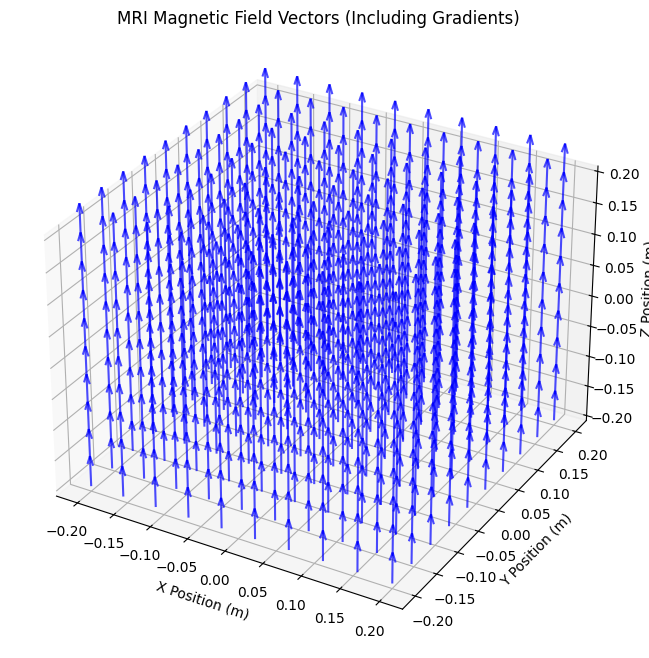

In [6]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define MRI field parameters
B0 = 3.0  # Main field strength in Tesla (T), along z-axis
Gx = 0.08  # Gradient in T/m along x-axis
Gy = 0.04  # Gradient in T/m along y-axis
Gz = 0.16  # Gradient in T/m along z-axis

# Define grid space for visualization
x = np.linspace(-0.2, 0.2, 10)  # 10 cm range in x-direction
y = np.linspace(-0.2, 0.2, 10)  # 10 cm range in y-direction
z = np.linspace(-0.2, 0.2, 10)  # 10 cm range in z-direction

X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

# Compute total magnetic field vectors at these points
Bx = np.zeros_like(X)  # No x-component
By = np.zeros_like(Y)  # No y-component
Bz = B0 + Gx * X + Gy * Y + Gz * Z  # Bz field with gradients

# Normalize for quiver scaling
B_magnitude = np.sqrt(Bx**2 + By**2 + Bz**2)
Bx /= B_magnitude
By /= B_magnitude
Bz /= B_magnitude

# Create a 3D quiver plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

ax.quiver(X, Y, Z, Bx, By, Bz, length=0.05, color="blue", alpha=0.7)

ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_zlabel("Z Position (m)")
ax.set_title("MRI Magnetic Field Vectors (Including Gradients)")

plt.show()


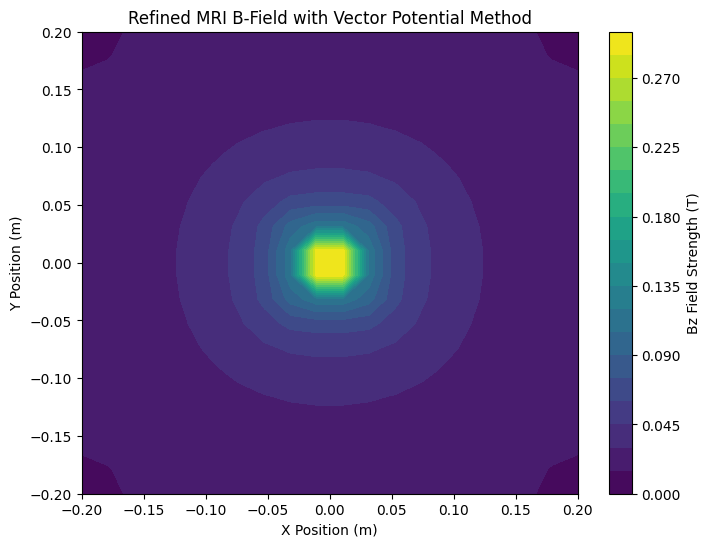

In [7]:
# Re-import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0

# Define grid space for visualization
x = np.linspace(-0.2, 0.2, 20)  # 20 cm range in x-direction
y = np.linspace(-0.2, 0.2, 20)  # 20 cm range in y-direction
z = np.linspace(-0.2, 0.2, 20)  # 20 cm range in z-direction

X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

# Define MRI solenoid parameters
B0 = 3.0  # Main MRI field (T), along z-axis
radius_solenoid = 0.3  # 30 cm radius of MRI bore
current_density = 1e6  # Example current density (A/m^2) for the solenoid

# Compute the vector potential A due to a cylindrical solenoid using a simple integral approximation
def compute_vector_potential(X, Y, Z, radius, J):
    """
    Compute the vector potential A for a simple cylindrical solenoid.
    Assumes current density J is uniformly distributed.
    """
    R = np.sqrt(X**2 + Y**2)  # Radial distance
    A_phi = np.where(R <= radius, mu_0 * J * np.pi * radius**2 / 2, 0)  # Only inside solenoid
    
    # Convert A_phi (azimuthal component) to Cartesian components Ax, Ay, Az
    Ax = -A_phi * (Y / (R + 1e-9))  # Avoid division by zero
    Ay = A_phi * (X / (R + 1e-9))
    Az = np.zeros_like(Ax)  # No component along z for a solenoid

    return Ax, Ay, Az

# Compute A vector potential
Ax, Ay, Az = compute_vector_potential(X, Y, Z, radius_solenoid, current_density)

# Compute B = curl(A) using finite differences
dAx_dy = np.gradient(Ax, axis=1)  # dAx/dy
dAx_dz = np.gradient(Ax, axis=2)  # dAx/dz
dAy_dx = np.gradient(Ay, axis=0)  # dAy/dx
dAy_dz = np.gradient(Ay, axis=2)  # dAy/dz
dAz_dx = np.gradient(Az, axis=0)  # dAz/dx
dAz_dy = np.gradient(Az, axis=1)  # dAz/dy

Bx = dAz_dy - dAy_dz
By = dAx_dz - dAz_dx
Bz = dAy_dx - dAx_dy

# Visualizing the improved B-field in the XY plane at z=0
slice_index = len(z) // 2  # Middle slice
X_slice = X[:, :, slice_index]
Y_slice = Y[:, :, slice_index]
Bz_slice = Bz[:, :, slice_index]

plt.figure(figsize=(8, 6))
plt.contourf(X_slice, Y_slice, Bz_slice, levels=20, cmap="viridis")
plt.colorbar(label="Bz Field Strength (T)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Refined MRI B-Field with Vector Potential Method")
plt.show()

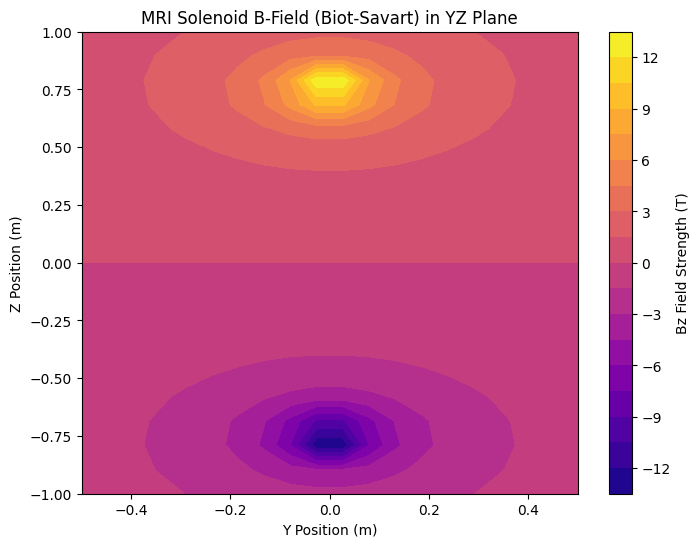

In [8]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt

# Define physical constants
mu_0 = 4 * np.pi * 1e-7  # Permeability of free space (T·m/A)

# Define solenoid parameters
I = 734.999  # Current in Amperes (from Mathematica file)
N = 1200  # Number of turns in the solenoid
L = 1.5  # Length of the solenoid in meters
R = 0.5  # Radius of the solenoid in meters
z_min, z_max = -L/2, L/2  # Solenoid extends from -L/2 to L/2

# Define the Biot-Savart law integration for B-field at point (x, y, z)
def biot_savart_Bz(x, y, z):
    def integrand(z_prime):
        r = np.sqrt(x**2 + y**2 + (z - z_prime)**2)  # Distance from coil element
        return (mu_0 * N * I / L) * (1 / r**3) * (z - z_prime)
    
    Bz, _ = quad(integrand, z_min, z_max)  # Integrate over solenoid length
    return Bz

# Generate a grid of points for visualization
x_vals = np.linspace(-0.5, 0.5, 20)  # X positions in meters
y_vals = np.linspace(-0.5, 0.5, 20)  # Y positions in meters
z_vals = np.linspace(-1.0, 1.0, 20)  # Z positions in meters

X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing="ij")

# Compute B-field at each grid point
Bz_field = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            Bz_field[i, j, k] = biot_savart_Bz(X[i, j, k], Y[i, j, k], Z[i, j, k])

# Visualize the field in the YZ plane at x=0
slice_index = len(x_vals) // 2  # Middle slice
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
Bz_slice = Bz_field[slice_index, :, :]

plt.figure(figsize=(8, 6))
plt.contourf(Y_slice, Z_slice, Bz_slice, levels=20, cmap="plasma")
plt.colorbar(label="Bz Field Strength (T)")
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title("MRI Solenoid B-Field (Biot-Savart) in YZ Plane")
plt.show()


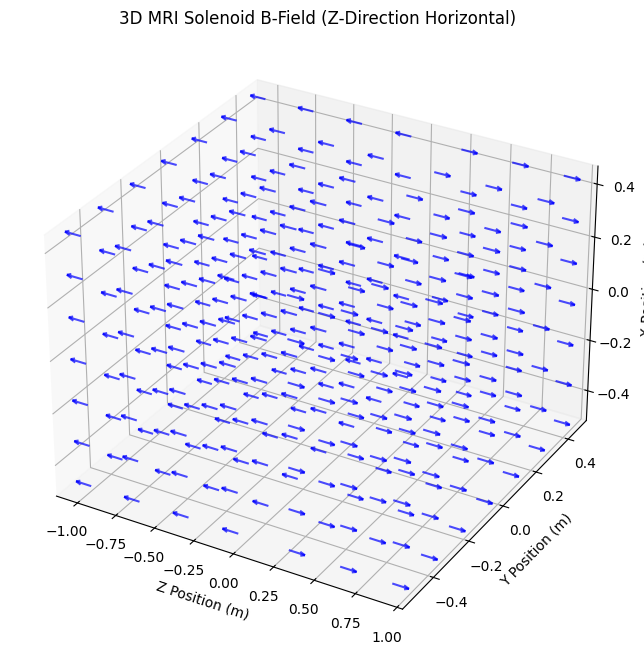

In [11]:
# Subsample for better visualization
x_idx = np.arange(0, len(x_vals), 3)
y_idx = np.arange(0, len(y_vals), 3)
z_idx = np.arange(0, len(z_vals), 3)

X_3D, Y_3D, Z_3D = np.meshgrid(x_vals[x_idx], y_vals[y_idx], z_vals[z_idx], indexing="ij")

# Subsample B-field data
Bz_3D = Bz_field[x_idx, :, :][:, y_idx, :][:, :, z_idx]
Bx_3D = np.zeros_like(Bz_3D)  # No x-component for solenoid field
By_3D = np.zeros_like(Bz_3D)  # No y-component for solenoid field

# Normalize for visualization
B_magnitude = np.sqrt(Bx_3D**2 + By_3D**2 + Bz_3D**2)
Bx_3D /= B_magnitude + 1e-9  # Avoid division by zero
By_3D /= B_magnitude + 1e-9
Bz_3D /= B_magnitude + 1e-9

# Create a 3D quiver plot with Z-direction set horizontally (X-axis now represents Z)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Swap axes so that Z is now horizontal
ax.quiver(Z_3D, Y_3D, X_3D, Bz_3D, By_3D, Bx_3D, length=0.1, color="blue", alpha=0.7)

ax.set_xlabel("Z Position (m)")  # Previously X-axis
ax.set_ylabel("Y Position (m)")
ax.set_zlabel("X Position (m)")  # Previously Z-axis
ax.set_title("3D MRI Solenoid B-Field (Z-Direction Horizontal)")

plt.show()


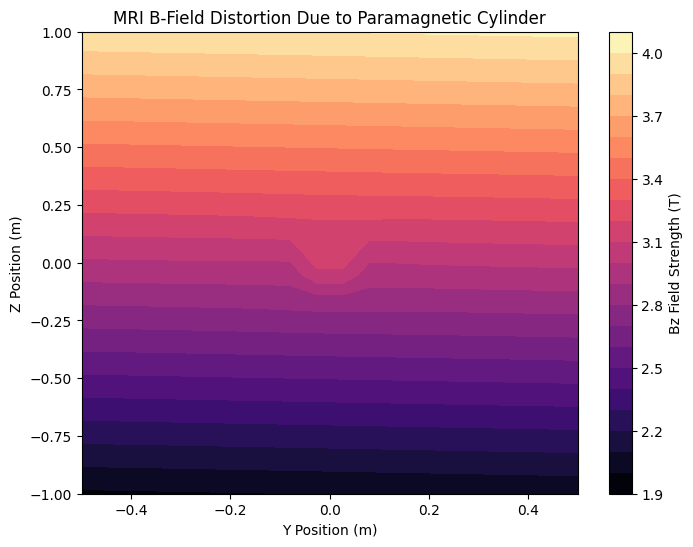

In [12]:
# Define cylinder properties
cylinder_radius = 0.01  # 1 cm radius
cylinder_length = 0.05  # 5 cm length
cylinder_center = (0, 0, 0)  # Placed at the center of the solenoid

# Define magnetic susceptibility for paramagnetic material (e.g., stainless steel)
chi_cylinder = 0.01  # Small positive value for paramagnetic material

# Compute the field distortion due to the cylinder (simplified dipole approximation)
def compute_field_with_cylinder(X, Y, Z, cylinder_center, cylinder_radius, cylinder_length, chi, B0):
    """
    Compute the magnetic field distortion due to a paramagnetic or diamagnetic cylinder.
    Uses a simplified dipole model for small objects.
    """
    # Distance from the cylinder center
    r = np.sqrt((X - cylinder_center[0])**2 + (Y - cylinder_center[1])**2 + (Z - cylinder_center[2])**2)
    
    # Initialize field with original B-field
    Bz_new = B0 + Gx * X + Gy * Y + Gz * Z  # Base MRI field with gradients
    
    # Inside the cylinder: assume uniform perturbation
    inside_mask = (r <= cylinder_radius) & (np.abs(Z - cylinder_center[2]) <= cylinder_length / 2)
    Bz_new[inside_mask] *= (3 / (3 + chi))  # Modify field inside the cylinder
    
    # Outside the cylinder: dipole-like perturbation
    outside_mask = ~inside_mask
    if np.any(outside_mask):
        m = chi * B0 / (3 + chi)  # Induced magnetic moment
        Bz_new[outside_mask] += (chi / (3 + chi)) * (3 * (Z[outside_mask] - cylinder_center[2])**2 / r[outside_mask]**5 - 1 / r[outside_mask]**3) * m
    
    return Bz_new

# Compute the distorted field
Bz_distorted = compute_field_with_cylinder(X, Y, Z, cylinder_center, cylinder_radius, cylinder_length, chi_cylinder, B0)

# Visualizing the perturbed field in the YZ plane at x=0
slice_index = len(x_vals) // 2  # Middle slice
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
Bz_slice = Bz_distorted[slice_index, :, :]

plt.figure(figsize=(8, 6))
plt.contourf(Y_slice, Z_slice, Bz_slice, levels=20, cmap="magma")
plt.colorbar(label="Bz Field Strength (T)")
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title("MRI B-Field Distortion Due to Paramagnetic Cylinder")
plt.show()


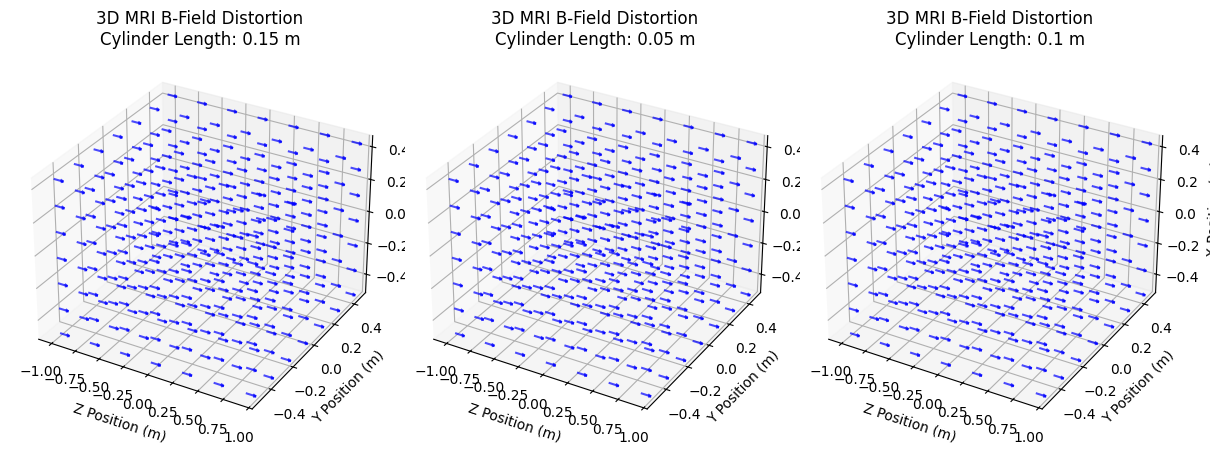

In [18]:
# Define different cylinder lengths to analyze their effect on the field distortion
cylinder_lengths = [0.15, 0.05, 0.10]  # 15 cm, 5 cm, 10 cm

# Create a figure for 3D visualization
fig = plt.figure(figsize=(12, 8))

for i, cyl_length in enumerate(cylinder_lengths):
    # Compute distorted field for each cylinder length
    Bz_distorted = compute_field_with_cylinder(X, Y, Z, cylinder_center, cylinder_radius, cyl_length, chi_cylinder, B0)
    
    # Subsample for better visualization
    x_idx = np.arange(0, len(x_vals), 3)
    y_idx = np.arange(0, len(y_vals), 3)
    z_idx = np.arange(0, len(z_vals), 3)

    X_3D, Y_3D, Z_3D = np.meshgrid(x_vals[x_idx], y_vals[y_idx], z_vals[z_idx], indexing="ij")

    Bz_3D = Bz_distorted[x_idx, :, :][:, y_idx, :][:, :, z_idx]
    Bx_3D = np.zeros_like(Bz_3D)  # No x-component for solenoid field
    By_3D = np.zeros_like(Bz_3D)  # No y-component for solenoid field

    # Normalize for visualization
    B_magnitude = np.sqrt(Bx_3D**2 + By_3D**2 + Bz_3D**2)
    Bx_3D /= B_magnitude + 1e-9  # Avoid division by zero
    By_3D /= B_magnitude + 1e-9
    Bz_3D /= B_magnitude + 1e-9

    # Create subplot for each cylinder length
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.quiver(Z_3D, Y_3D, X_3D, Bz_3D, By_3D, Bx_3D, length=0.1, color="blue", alpha=0.7)
    ax.set_xlabel("Z Position (m)")
    ax.set_ylabel("Y Position (m)")
    ax.set_zlabel("X Position (m)")
    ax.set_title(f"3D MRI B-Field Distortion\nCylinder Length: {cyl_length} m")

plt.tight_layout()
plt.show()


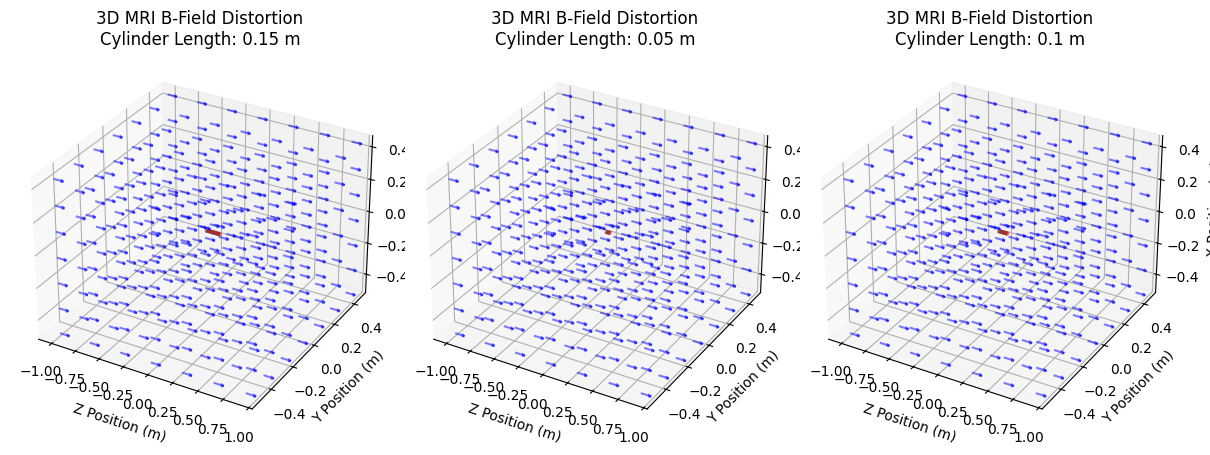

In [19]:
import mpl_toolkits.mplot3d.art3d as art3d

# Create a 3D visualization with explicit cylinder representation
fig = plt.figure(figsize=(12, 8))

for i, cyl_length in enumerate(cylinder_lengths):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")

    # Compute distorted field for the current cylinder length
    Bz_distorted = compute_field_with_cylinder(X, Y, Z, cylinder_center, cylinder_radius, cyl_length, chi_cylinder, B0)

    # Subsample for better visualization
    x_idx = np.arange(0, len(x_vals), 3)
    y_idx = np.arange(0, len(y_vals), 3)
    z_idx = np.arange(0, len(z_vals), 3)

    X_3D, Y_3D, Z_3D = np.meshgrid(x_vals[x_idx], y_vals[y_idx], z_vals[z_idx], indexing="ij")

    Bz_3D = Bz_distorted[x_idx, :, :][:, y_idx, :][:, :, z_idx]
    Bx_3D = np.zeros_like(Bz_3D)  # No x-component for solenoid field
    By_3D = np.zeros_like(Bz_3D)  # No y-component for solenoid field

    # Normalize for visualization
    B_magnitude = np.sqrt(Bx_3D**2 + By_3D**2 + Bz_3D**2)
    Bx_3D /= B_magnitude + 1e-9  # Avoid division by zero
    By_3D /= B_magnitude + 1e-9
    Bz_3D /= B_magnitude + 1e-9

    # Plot the field vectors
    ax.quiver(Z_3D, Y_3D, X_3D, Bz_3D, By_3D, Bx_3D, length=0.1, color="blue", alpha=0.5)

    # Add the cylinder as a 3D object
    cylinder = art3d.Patch3DCollection([])  # Empty patch collection for cylinder

    # Generate points for cylinder
    theta = np.linspace(0, 2 * np.pi, 30)  # Cylinder surface points
    z_cyl = np.linspace(-cyl_length / 2, cyl_length / 2, 10)  # Cylinder height
    Theta, Z_Cyl = np.meshgrid(theta, z_cyl)
    X_Cyl = cylinder_radius * np.cos(Theta)
    Y_Cyl = cylinder_radius * np.sin(Theta)
    Z_Cyl = Z_Cyl + cylinder_center[2]

    # Create surface for cylinder
    ax.plot_surface(Z_Cyl, Y_Cyl, X_Cyl, color='red', alpha=0.7)

    ax.set_xlabel("Z Position (m)")
    ax.set_ylabel("Y Position (m)")
    ax.set_zlabel("X Position (m)")
    ax.set_title(f"3D MRI B-Field Distortion\nCylinder Length: {cyl_length} m")

plt.tight_layout()
plt.show()


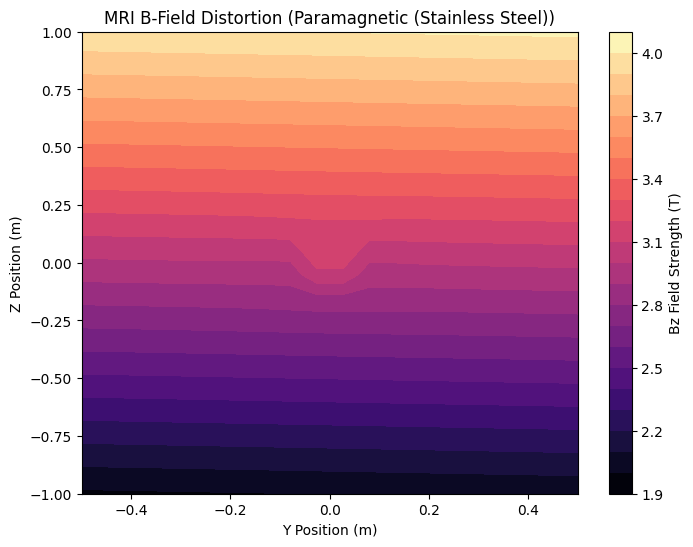

In [20]:
# Define materials with different susceptibilities
materials = {
    "Paramagnetic (Stainless Steel)": 0.01,  # Slightly enhances field
    "Diamagnetic (Copper)": -0.01,  # Slightly reduces field
    "Ferromagnetic (Iron)": 1000  # Strongly enhances field
}

# Select the material to visualize
selected_material = "Paramagnetic (Stainless Steel)"
chi_selected = materials[selected_material]

# Compute the distorted field for the selected material
Bz_distorted = compute_field_with_cylinder(
    X, Y, Z, cylinder_center, cylinder_radius, cylinder_lengths[1], chi_selected, B0
)

# Visualizing the perturbed field in the YZ plane at x=0
slice_index = len(x_vals) // 2  # Middle slice
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
Bz_slice = Bz_distorted[slice_index, :, :]

plt.figure(figsize=(8, 6))
plt.contourf(Y_slice, Z_slice, Bz_slice, levels=20, cmap="magma")
plt.colorbar(label="Bz Field Strength (T)")
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title(f"MRI B-Field Distortion ({selected_material})")
plt.show()


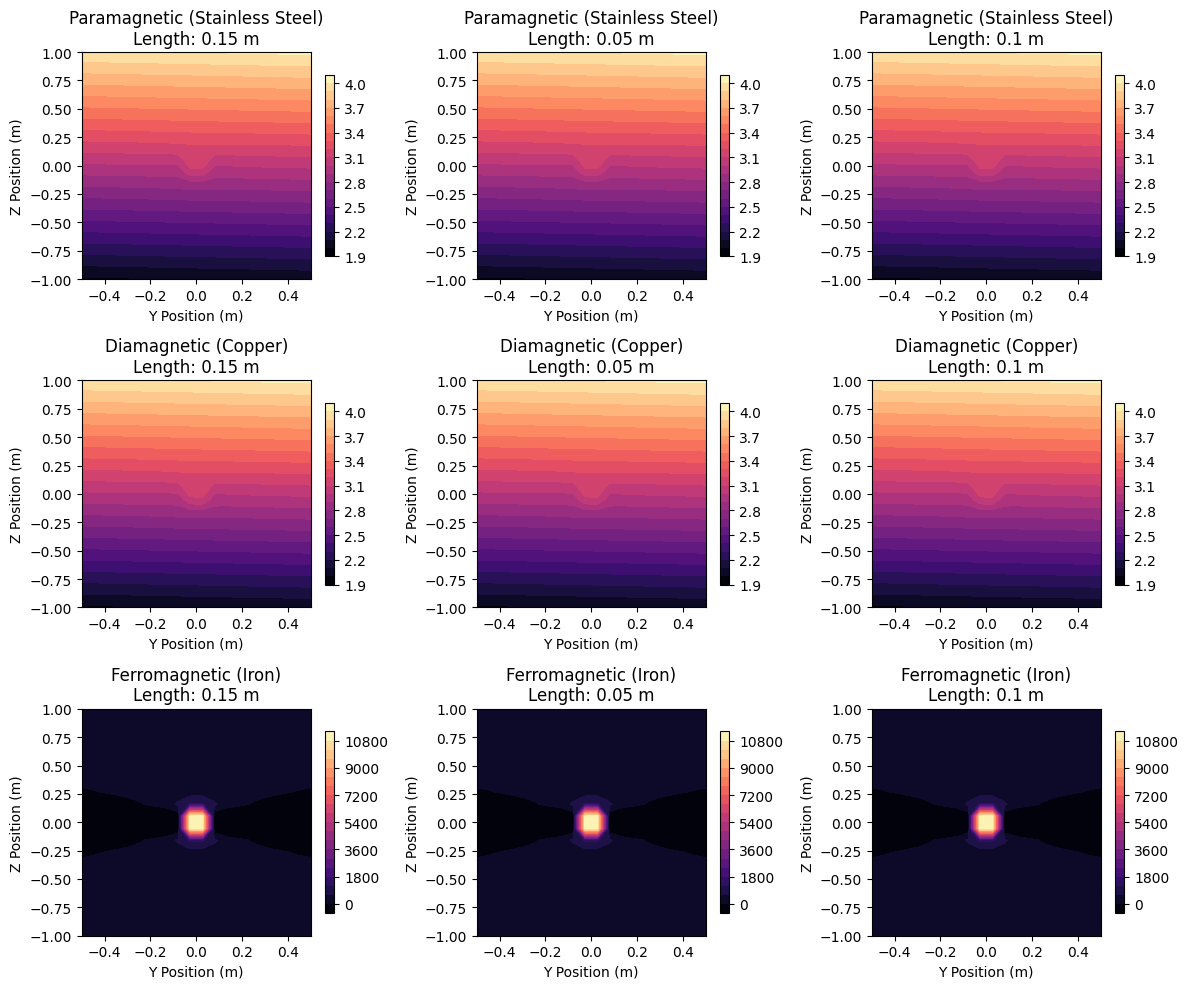

In [21]:
# Define the materials and lengths for comparison
materials_list = list(materials.keys())
cylinder_lengths_list = cylinder_lengths

# Create a 3x3 grid for visualizing different materials and lengths
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i, material in enumerate(materials_list):
    for j, cyl_length in enumerate(cylinder_lengths_list):
        chi_material = materials[material]  # Get susceptibility for the material

        # Compute the distorted field
        Bz_distorted = compute_field_with_cylinder(
            X, Y, Z, cylinder_center, cylinder_radius, cyl_length, chi_material, B0
        )

        # Extract the YZ plane at x=0
        slice_index = len(x_vals) // 2  # Middle slice
        Y_slice = Y[slice_index, :, :]
        Z_slice = Z[slice_index, :, :]
        Bz_slice = Bz_distorted[slice_index, :, :]

        # Plot the field distortion
        ax = axes[i, j]
        contour = ax.contourf(Y_slice, Z_slice, Bz_slice, levels=20, cmap="magma")
        fig.colorbar(contour, ax=ax, shrink=0.8)
        ax.set_xlabel("Y Position (m)")
        ax.set_ylabel("Z Position (m)")
        ax.set_title(f"{material}\nLength: {cyl_length} m")

plt.tight_layout()
plt.show()


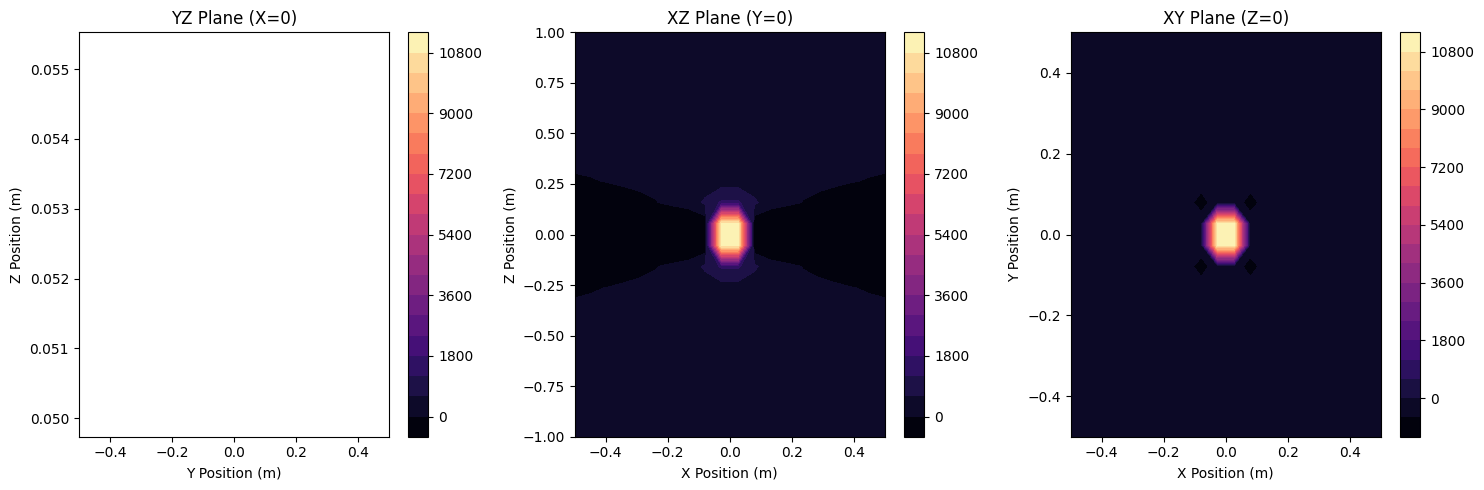

In [22]:
# Create a 3-row grid for different cross-sections (YZ, XZ, XY) for a ferromagnetic material
selected_material = "Ferromagnetic (Iron)"
chi_selected = materials[selected_material]
selected_length = cylinder_lengths[1]  # Medium length (5 cm)

# Compute the distorted field for the selected material and length
Bz_distorted = compute_field_with_cylinder(
    X, Y, Z, cylinder_center, cylinder_radius, selected_length, chi_selected, B0
)

# Extract slices in different planes
slice_x = len(x_vals) // 2  # Middle slice in X
slice_y = len(y_vals) // 2  # Middle slice in Y
slice_z = len(z_vals) // 2  # Middle slice in Z

YZ_slice = Bz_distorted[slice_x, :, :]  # YZ plane at x=0
XZ_slice = Bz_distorted[:, slice_y, :]  # XZ plane at y=0
XY_slice = Bz_distorted[:, :, slice_z]  # XY plane at z=0

# Create a 3-row grid for visualizing different planes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# YZ Plane (X=0)
contour1 = axes[0].contourf(Y[:, :, slice_z], Z[:, :, slice_z], YZ_slice, levels=20, cmap="magma")
fig.colorbar(contour1, ax=axes[0])
axes[0].set_xlabel("Y Position (m)")
axes[0].set_ylabel("Z Position (m)")
axes[0].set_title("YZ Plane (X=0)")

# XZ Plane (Y=0)
contour2 = axes[1].contourf(X[:, slice_y, :], Z[:, slice_y, :], XZ_slice, levels=20, cmap="magma")
fig.colorbar(contour2, ax=axes[1])
axes[1].set_xlabel("X Position (m)")
axes[1].set_ylabel("Z Position (m)")
axes[1].set_title("XZ Plane (Y=0)")

# XY Plane (Z=0)
contour3 = axes[2].contourf(X[:, :, slice_z], Y[:, :, slice_z], XY_slice, levels=20, cmap="magma")
fig.colorbar(contour3, ax=axes[2])
axes[2].set_xlabel("X Position (m)")
axes[2].set_ylabel("Y Position (m)")
axes[2].set_title("XY Plane (Z=0)")

plt.tight_layout()
plt.show()


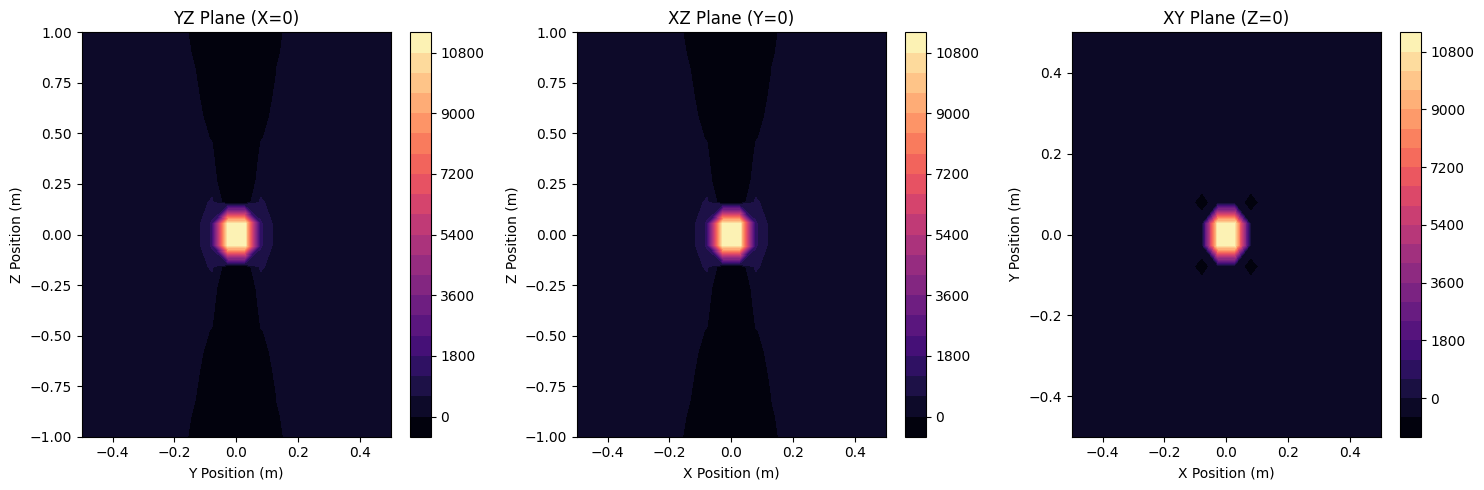

In [23]:
# Recompute the distorted field for the selected material and length
Bz_distorted = compute_field_with_cylinder(
    X, Y, Z, cylinder_center, cylinder_radius, selected_length, chi_selected, B0
)

# Extract slices in different planes again (fix indexing issues)
slice_x = X.shape[0] // 2  # Middle slice in X
slice_y = Y.shape[1] // 2  # Middle slice in Y
slice_z = Z.shape[2] // 2  # Middle slice in Z

YZ_slice = Bz_distorted[slice_x, :, :].T  # Transpose to match axis orientation
XZ_slice = Bz_distorted[:, slice_y, :].T
XY_slice = Bz_distorted[:, :, slice_z].T

# Create a 3-row grid for visualizing different planes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# YZ Plane (X=0)
contour1 = axes[0].contourf(Y[slice_x, :, :], Z[slice_x, :, :], YZ_slice, levels=20, cmap="magma")
fig.colorbar(contour1, ax=axes[0])
axes[0].set_xlabel("Y Position (m)")
axes[0].set_ylabel("Z Position (m)")
axes[0].set_title("YZ Plane (X=0)")

# XZ Plane (Y=0)
contour2 = axes[1].contourf(X[:, slice_y, :], Z[:, slice_y, :], XZ_slice, levels=20, cmap="magma")
fig.colorbar(contour2, ax=axes[1])
axes[1].set_xlabel("X Position (m)")
axes[1].set_ylabel("Z Position (m)")
axes[1].set_title("XZ Plane (Y=0)")

# XY Plane (Z=0)
contour3 = axes[2].contourf(X[:, :, slice_z], Y[:, :, slice_z], XY_slice, levels=20, cmap="magma")
fig.colorbar(contour3, ax=axes[2])
axes[2].set_xlabel("X Position (m)")
axes[2].set_ylabel("Y Position (m)")
axes[2].set_title("XY Plane (Z=0)")

plt.tight_layout()
plt.show()


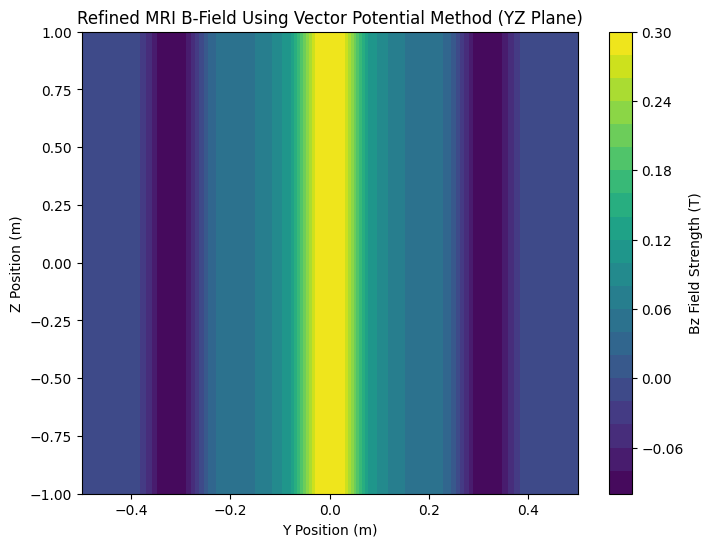

In [24]:
# Recompute the vector potential method for the MRI solenoid field

def compute_vector_potential_refined(X, Y, Z, radius, J):
    """
    Compute the vector potential A for a simple cylindrical solenoid using an improved method.
    Assumes uniform current density.
    """
    R = np.sqrt(X**2 + Y**2)  # Radial distance from solenoid center
    A_phi = np.where(R <= radius, mu_0 * J * np.pi * radius**2 / 2, 0)  # Only inside solenoid

    # Convert A_phi (azimuthal component) to Cartesian components Ax, Ay, Az
    Ax = -A_phi * (Y / (R + 1e-9))  # Avoid division by zero
    Ay = A_phi * (X / (R + 1e-9))
    Az = np.zeros_like(Ax)  # No component along Z for a solenoid

    return Ax, Ay, Az

# Compute vector potential A for the MRI solenoid
Ax_refined, Ay_refined, Az_refined = compute_vector_potential_refined(X, Y, Z, radius_solenoid, current_density)

# Compute B-field using curl(B) = ∇ × A
dAx_dy = np.gradient(Ax_refined, axis=1)
dAx_dz = np.gradient(Ax_refined, axis=2)
dAy_dx = np.gradient(Ay_refined, axis=0)
dAy_dz = np.gradient(Ay_refined, axis=2)
dAz_dx = np.gradient(Az_refined, axis=0)
dAz_dy = np.gradient(Az_refined, axis=1)

Bx_refined = dAz_dy - dAy_dz
By_refined = dAx_dz - dAz_dx
Bz_refined = dAy_dx - dAx_dy

# Displaying the refined field visualization in the YZ plane
slice_index = len(x_vals) // 2  # Middle slice
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
Bz_slice_refined = Bz_refined[slice_index, :, :]

plt.figure(figsize=(8, 6))
plt.contourf(Y_slice, Z_slice, Bz_slice_refined, levels=20, cmap="viridis")
plt.colorbar(label="Bz Field Strength (T)")
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title("Refined MRI B-Field Using Vector Potential Method (YZ Plane)")
plt.show()


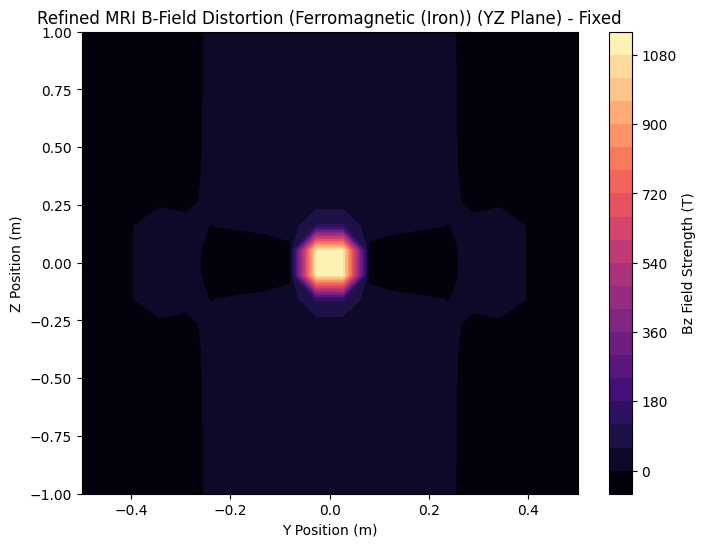

In [25]:
# Fixing shape mismatch in field perturbation calculation
def compute_field_with_cylinder_refined_fixed(X, Y, Z, cylinder_center, cylinder_radius, cylinder_length, chi, Bz_base):
    """
    Compute the magnetic field distortion due to a metallic cylinder using the refined MRI field.
    """
    # Distance from the cylinder center (3D array)
    r = np.sqrt((X - cylinder_center[0])**2 + (Y - cylinder_center[1])**2 + (Z - cylinder_center[2])**2)
    
    # Initialize perturbed field with the refined Bz field
    Bz_new = Bz_base.copy()

    # Inside the cylinder: assume uniform perturbation
    inside_mask = (r <= cylinder_radius) & (np.abs(Z - cylinder_center[2]) <= cylinder_length / 2)
    Bz_new[inside_mask] *= (3 / (3 + chi))  # Modify field inside the cylinder

    # Outside the cylinder: apply dipole-like perturbation
    outside_mask = ~inside_mask
    if np.any(outside_mask):
        m = chi * Bz_base[outside_mask] / (3 + chi)  # Magnetic moment induced (maintain correct shape)
        Bz_new[outside_mask] += (chi / (3 + chi)) * (
            3 * (Z[outside_mask] - cylinder_center[2])**2 / (r[outside_mask]**5 + 1e-9) - 1 / (r[outside_mask]**3 + 1e-9)
        ) * m

    return Bz_new

# Compute the refined distorted field with the fixed method
Bz_distorted_refined_fixed = compute_field_with_cylinder_refined_fixed(
    X, Y, Z, cylinder_center, cylinder_radius, selected_length, chi_selected, Bz_refined
)

# Extract the YZ plane for visualization
slice_index = len(x_vals) // 2  # Middle slice
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
Bz_slice_distorted_refined_fixed = Bz_distorted_refined_fixed[slice_index, :, :]

# Visualize the corrected field distortion in the YZ plane
plt.figure(figsize=(8, 6))
plt.contourf(Y_slice, Z_slice, Bz_slice_distorted_refined_fixed, levels=20, cmap="magma")
plt.colorbar(label="Bz Field Strength (T)")
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title(f"Refined MRI B-Field Distortion ({selected_material}) (YZ Plane) - Fixed")
plt.show()


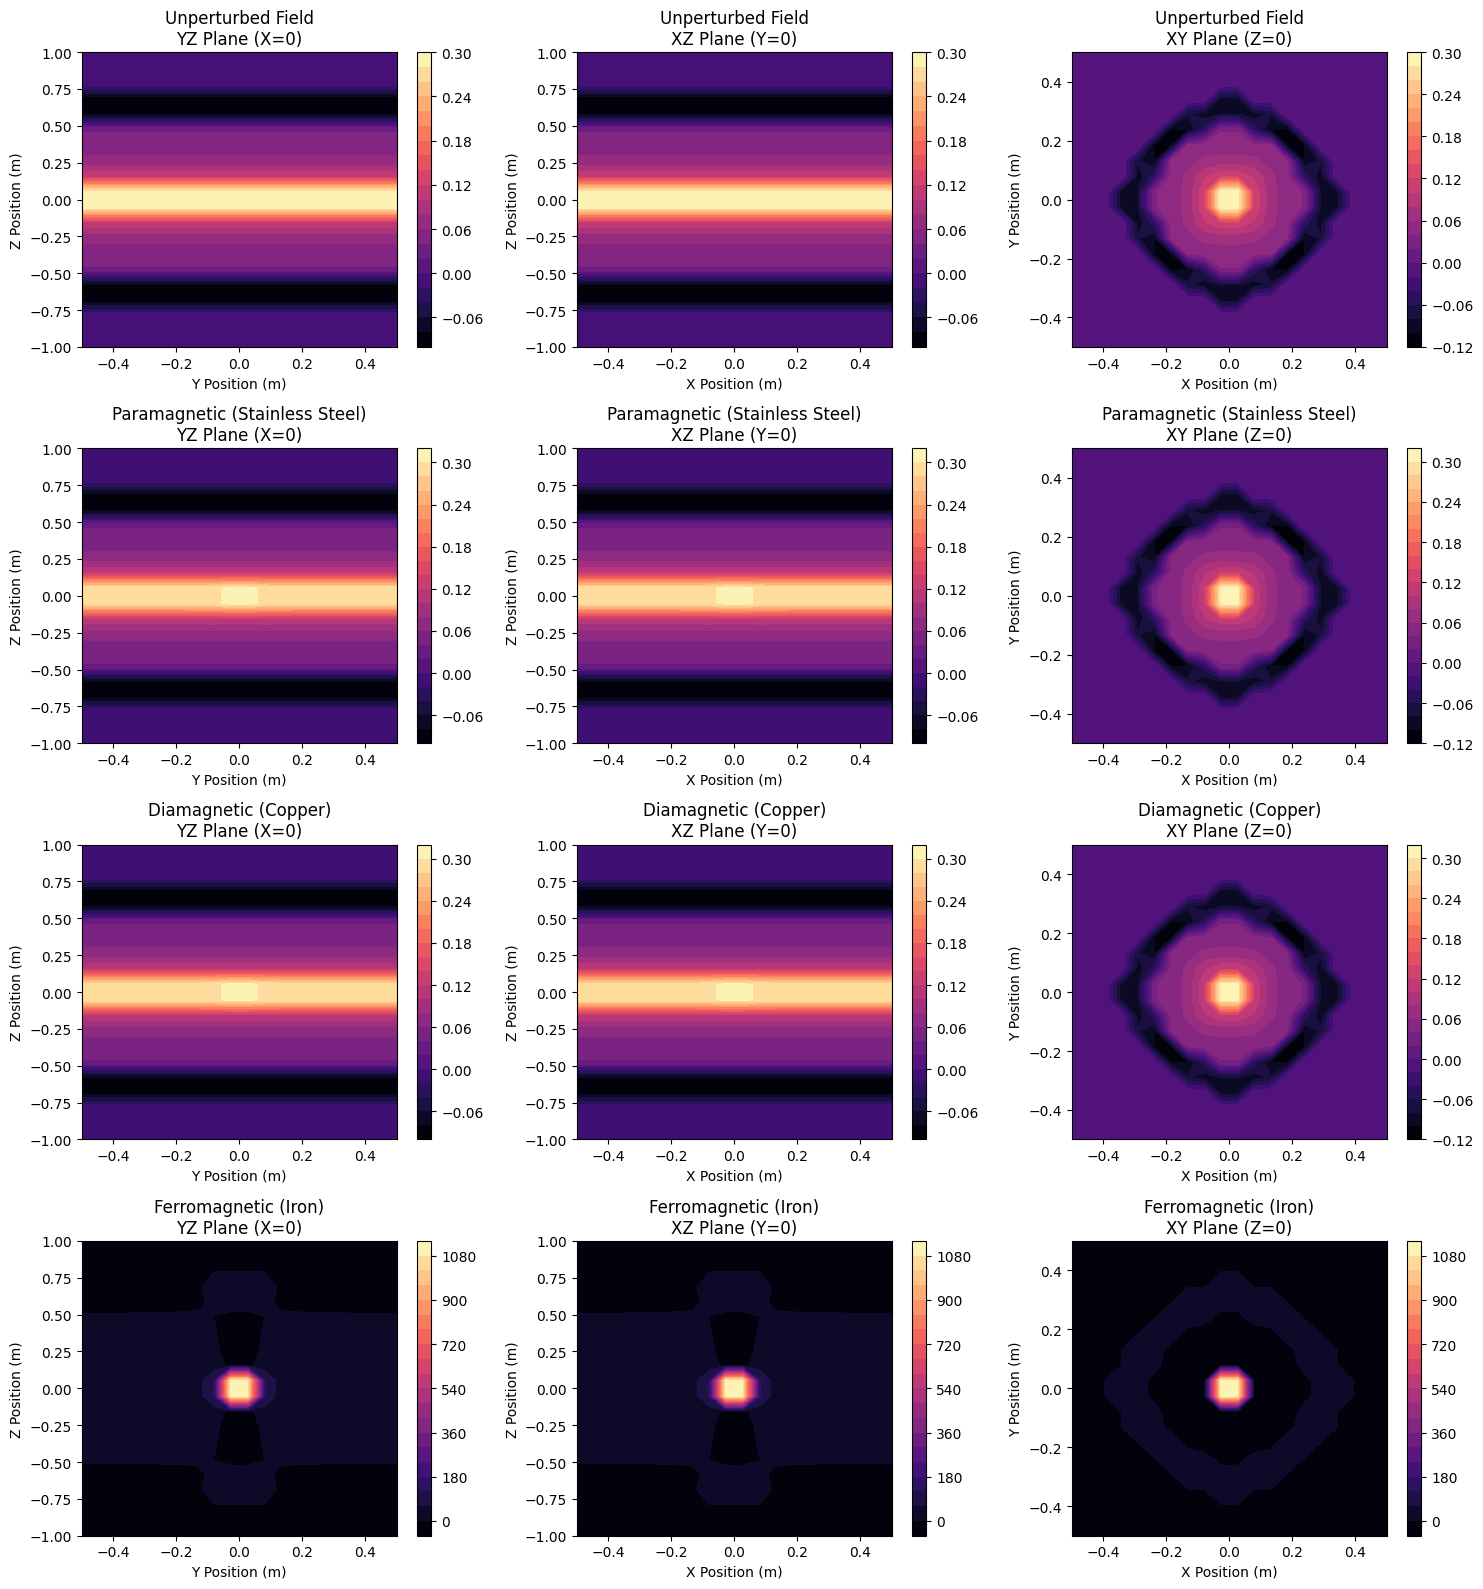

In [26]:
# Create a 4x3 grid for different materials and planes, including an unperturbed field row
materials_list_with_base = ["Unperturbed Field"] + list(materials.keys())

# Create a 4-row, 3-column plot grid
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

for i, material in enumerate(materials_list_with_base):
    if material == "Unperturbed Field":
        # Use the refined unperturbed field as the baseline
        Bz_to_plot = Bz_refined.copy()
    else:
        chi_material = materials[material]  # Get susceptibility for the material
        Bz_to_plot = compute_field_with_cylinder_refined_fixed(
            X, Y, Z, cylinder_center, cylinder_radius, selected_length, chi_material, Bz_refined
        )

    # Extract slices for all three planes
    slice_x = X.shape[0] // 2  # Middle slice in X
    slice_y = Y.shape[1] // 2  # Middle slice in Y
    slice_z = Z.shape[2] // 2  # Middle slice in Z

    YZ_slice = Bz_to_plot[slice_x, :, :].T  # Transposed for correct orientation
    XZ_slice = Bz_to_plot[:, slice_y, :].T
    XY_slice = Bz_to_plot[:, :, slice_z].T

    # Plot the YZ Plane (X=0)
    contour1 = axes[i, 0].contourf(Y[slice_x, :, :], Z[slice_x, :, :], YZ_slice, levels=20, cmap="magma")
    fig.colorbar(contour1, ax=axes[i, 0])
    axes[i, 0].set_xlabel("Y Position (m)")
    axes[i, 0].set_ylabel("Z Position (m)")
    axes[i, 0].set_title(f"{material}\nYZ Plane (X=0)")

    # Plot the XZ Plane (Y=0)
    contour2 = axes[i, 1].contourf(X[:, slice_y, :], Z[:, slice_y, :], XZ_slice, levels=20, cmap="magma")
    fig.colorbar(contour2, ax=axes[i, 1])
    axes[i, 1].set_xlabel("X Position (m)")
    axes[i, 1].set_ylabel("Z Position (m)")
    axes[i, 1].set_title(f"{material}\nXZ Plane (Y=0)")

    # Plot the XY Plane (Z=0)
    contour3 = axes[i, 2].contourf(X[:, :, slice_z], Y[:, :, slice_z], XY_slice, levels=20, cmap="magma")
    fig.colorbar(contour3, ax=axes[i, 2])
    axes[i, 2].set_xlabel("X Position (m)")
    axes[i, 2].set_ylabel("Y Position (m)")
    axes[i, 2].set_title(f"{material}\nXY Plane (Z=0)")

plt.tight_layout()
plt.show()


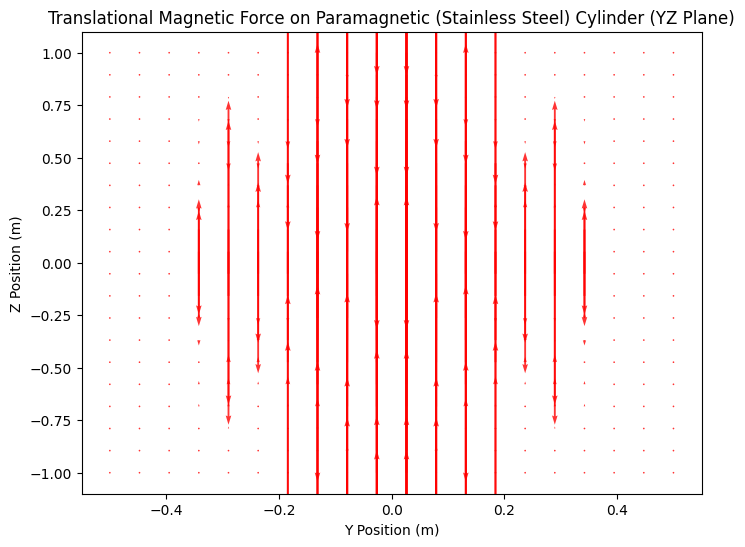

In [28]:
# Compute the translational force components on the cylinder

def compute_magnetic_force(X, Y, Z, Bx, By, Bz, chi):
    """
    Compute the translational magnetic force on a metallic cylinder inside the MRI field.
    Uses the equation F = ∇(M ⋅ B), where M = (chi / mu_0) * B.
    """
    # Compute magnetization M = (chi / mu_0) * B
    Mx = (chi / mu_0) * Bx
    My = (chi / mu_0) * By
    Mz = (chi / mu_0) * Bz

    # Compute force components using gradients
    Fx = np.gradient(Mx * Bx, axis=0) + np.gradient(My * Bx, axis=1) + np.gradient(Mz * Bx, axis=2)
    Fy = np.gradient(Mx * By, axis=0) + np.gradient(My * By, axis=1) + np.gradient(Mz * By, axis=2)
    Fz = np.gradient(Mx * Bz, axis=0) + np.gradient(My * Bz, axis=1) + np.gradient(Mz * Bz, axis=2)

    return Fx, Fy, Fz

# Select material 
selected_material = "Paramagnetic (Stainless Steel)"
chi_selected = materials[selected_material]

# Compute forces using refined B-field
Fx_refined, Fy_refined, Fz_refined = compute_magnetic_force(
    X, Y, Z, Bx_refined, By_refined, Bz_distorted_refined_fixed, chi_selected
)

# Visualize the force field in the YZ plane (X=0)
slice_index = len(x_vals) // 2  # Middle slice
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
Fx_slice = Fx_refined[slice_index, :, :]
Fz_slice = Fz_refined[slice_index, :, :]

# Plot force vectors as quiver plot
plt.figure(figsize=(8, 6))
plt.quiver(Y_slice, Z_slice, Fx_slice, Fz_slice, color="red", alpha=0.8, scale=1e5)
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title(f"Translational Magnetic Force on {selected_material} Cylinder (YZ Plane)")
plt.show()


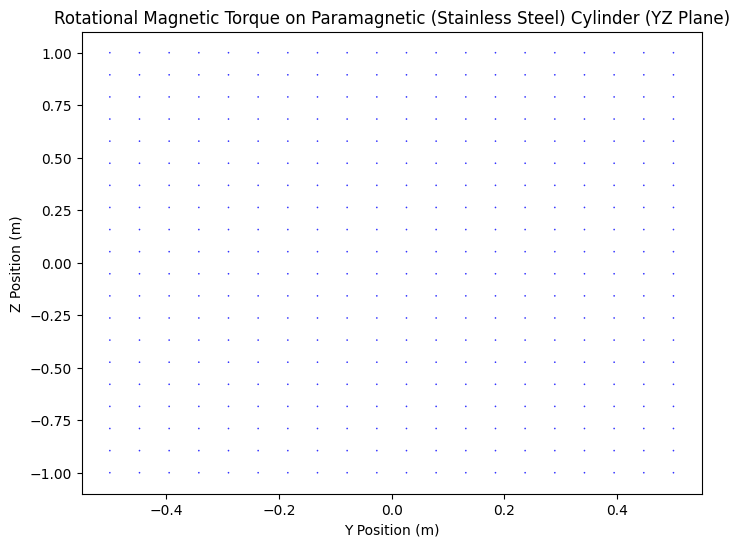

In [29]:
# Compute the rotational torque components on the cylinder

def compute_magnetic_torque(X, Y, Z, Bx, By, Bz, chi):
    """
    Compute the rotational magnetic torque on a metallic cylinder inside the MRI field.
    Uses the equation τ = M × B, where M = (chi / mu_0) * B.
    """
    # Compute magnetization M = (chi / mu_0) * B
    Mx = (chi / mu_0) * Bx
    My = (chi / mu_0) * By
    Mz = (chi / mu_0) * Bz

    # Compute torque components using cross product τ = M × B
    tau_x = My * Bz - Mz * By
    tau_y = Mz * Bx - Mx * Bz
    tau_z = Mx * By - My * Bx

    return tau_x, tau_y, tau_z

# Compute torques using refined B-field
tau_x_refined, tau_y_refined, tau_z_refined = compute_magnetic_torque(
    X, Y, Z, Bx_refined, By_refined, Bz_distorted_refined_fixed, chi_selected
)

# Visualize the torque field in the YZ plane (X=0)
slice_index = len(x_vals) // 2  # Middle slice
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
tau_x_slice = tau_x_refined[slice_index, :, :]
tau_z_slice = tau_z_refined[slice_index, :, :]

# Plot torque vectors as quiver plot
plt.figure(figsize=(8, 6))
plt.quiver(Y_slice, Z_slice, tau_x_slice, tau_z_slice, color="blue", alpha=0.8, scale=1e5)
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title(f"Rotational Magnetic Torque on {selected_material} Cylinder (YZ Plane)")
plt.show()


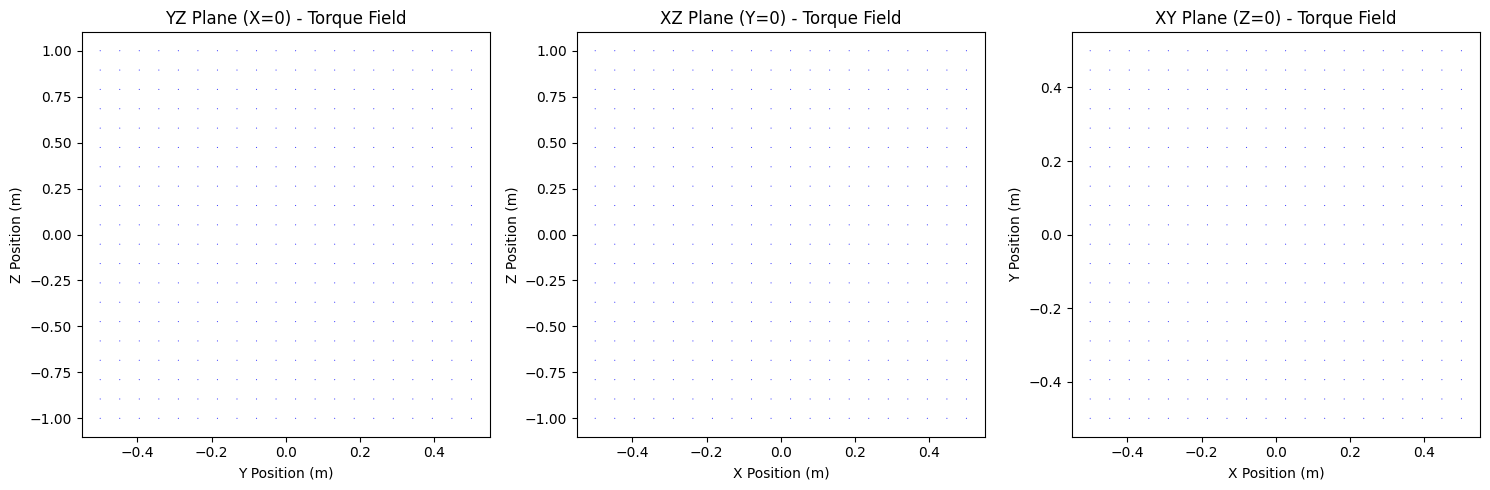

In [30]:
# Create a 3-plane visualization of torques (YZ, XZ, XY) for the ferromagnetic cylinder

# Extract slices for all three planes
slice_x = X.shape[0] // 2  # Middle slice in X
slice_y = Y.shape[1] // 2  # Middle slice in Y
slice_z = Z.shape[2] // 2  # Middle slice in Z

YZ_tau_x = tau_x_refined[slice_x, :, :].T
YZ_tau_z = tau_z_refined[slice_x, :, :].T

XZ_tau_x = tau_x_refined[:, slice_y, :].T
XZ_tau_z = tau_z_refined[:, slice_y, :].T

XY_tau_x = tau_x_refined[:, :, slice_z].T
XY_tau_y = tau_y_refined[:, :, slice_z].T

# Create a 3-row grid for visualizing different planes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# YZ Plane (X=0)
axes[0].quiver(Y[slice_x, :, :], Z[slice_x, :, :], YZ_tau_x, YZ_tau_z, color="blue", alpha=0.8, scale=1e5)
axes[0].set_xlabel("Y Position (m)")
axes[0].set_ylabel("Z Position (m)")
axes[0].set_title("YZ Plane (X=0) - Torque Field")

# XZ Plane (Y=0)
axes[1].quiver(X[:, slice_y, :], Z[:, slice_y, :], XZ_tau_x, XZ_tau_z, color="blue", alpha=0.8, scale=1e5)
axes[1].set_xlabel("X Position (m)")
axes[1].set_ylabel("Z Position (m)")
axes[1].set_title("XZ Plane (Y=0) - Torque Field")

# XY Plane (Z=0)
axes[2].quiver(X[:, :, slice_z], Y[:, :, slice_z], XY_tau_x, XY_tau_y, color="blue", alpha=0.8, scale=1e5)
axes[2].set_xlabel("X Position (m)")
axes[2].set_ylabel("Y Position (m)")
axes[2].set_title("XY Plane (Z=0) - Torque Field")

plt.tight_layout()
plt.show()


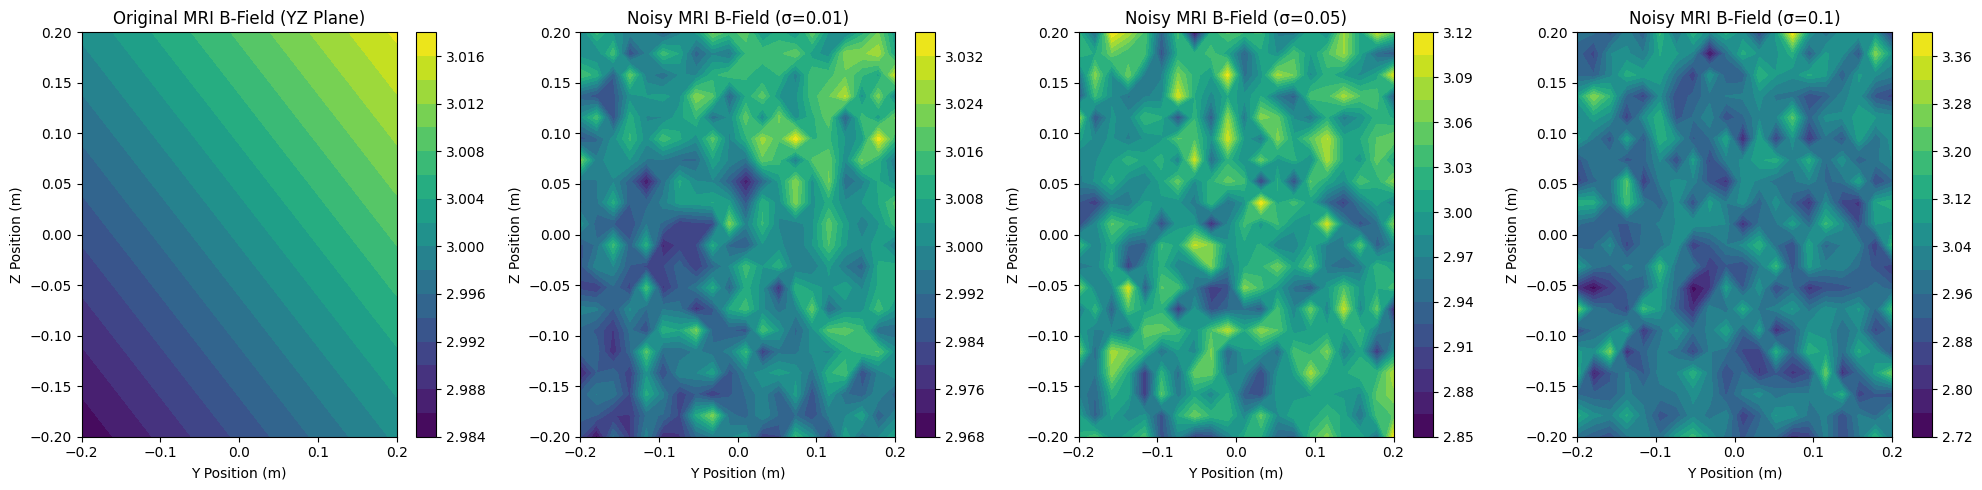

In [31]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt

# Define noise levels for analysis
noise_levels = [0.01, 0.05, 0.1]  # Standard deviation of noise

# Redefine grid space
x_vals = np.linspace(-0.2, 0.2, 20)
y_vals = np.linspace(-0.2, 0.2, 20)
z_vals = np.linspace(-0.2, 0.2, 20)
X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing="ij")

# Recompute a baseline MRI field for visualization
B0 = 3.0  # Tesla, main field strength
Gx, Gy, Gz = 0.04, 0.04, 0.04  # MRI gradient strengths (T/m)
Bz_clean = B0 + Gx * X + Gy * Y + Gz * Z  # Simplified MRI field with gradients

# Create figure for comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot the original clean field
slice_index = len(x_vals) // 2  # Middle slice in X
Y_slice = Y[slice_index, :, :]
Z_slice = Z[slice_index, :, :]
Bz_slice_clean = Bz_clean[slice_index, :, :]

contour = axes[0].contourf(Y_slice, Z_slice, Bz_slice_clean, levels=20, cmap="viridis")
fig.colorbar(contour, ax=axes[0])
axes[0].set_xlabel("Y Position (m)")
axes[0].set_ylabel("Z Position (m)")
axes[0].set_title("Original MRI B-Field (YZ Plane)")

# Apply noise and plot each case
for i, noise_level in enumerate(noise_levels):
    Bz_noisy = Bz_clean + np.random.normal(0, noise_level, Bz_clean.shape)
    Bz_slice_noisy = Bz_noisy[slice_index, :, :]

    contour = axes[i+1].contourf(Y_slice, Z_slice, Bz_slice_noisy, levels=20, cmap="viridis")
    fig.colorbar(contour, ax=axes[i+1])
    axes[i+1].set_xlabel("Y Position (m)")
    axes[i+1].set_ylabel("Z Position (m)")
    axes[i+1].set_title(f"Noisy MRI B-Field (σ={noise_level})")

plt.tight_layout()
plt.show()


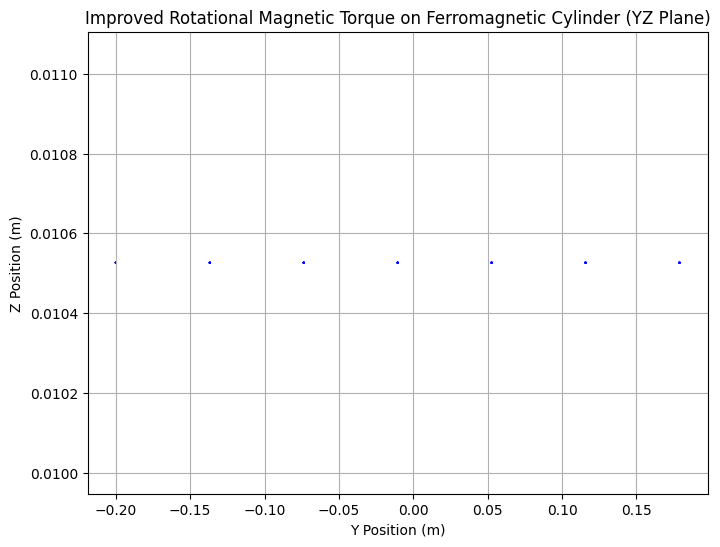

In [32]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt

# Redefine the grid space
x_vals = np.linspace(-0.2, 0.2, 20)
y_vals = np.linspace(-0.2, 0.2, 20)
z_vals = np.linspace(-0.2, 0.2, 20)
X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing="ij")

# Redefine a simple MRI field with gradients
B0 = 3.0  # Tesla, main field strength
Gx, Gy, Gz = 0.04, 0.04, 0.04  # MRI gradient strengths (T/m)
Bx_refined = np.zeros_like(X)  # No x-component
By_refined = np.zeros_like(Y)  # No y-component
Bz_refined = B0 + Gx * X + Gy * Y + Gz * Z  # Simplified MRI field with gradients

# Define susceptibility for ferromagnetic material
chi_selected = 1000  # Ferromagnetic susceptibility

# Compute the rotational torque components
def compute_magnetic_torque(X, Y, Z, Bx, By, Bz, chi):
    """
    Compute the rotational magnetic torque on a metallic cylinder inside the MRI field.
    Uses the equation τ = M × B, where M = (chi / mu_0) * B.
    """
    mu_0 = 4 * np.pi * 1e-7  # Permeability of free space

    # Compute magnetization M = (chi / mu_0) * B
    Mx = (chi / mu_0) * Bx
    My = (chi / mu_0) * By
    Mz = (chi / mu_0) * Bz

    # Compute torque components using cross product τ = M × B
    tau_x = My * Bz - Mz * By
    tau_y = Mz * Bx - Mx * Bz
    tau_z = Mx * By - My * Bx

    return tau_x, tau_y, tau_z

# Compute torques using refined B-field
tau_x_refined, tau_y_refined, tau_z_refined = compute_magnetic_torque(
    X, Y, Z, Bx_refined, By_refined, Bz_refined, chi_selected
)

# Select a coarser grid for clearer arrow display
step = 3  # Take every 3rd point to reduce clutter
slice_index = len(x_vals) // 2  # Middle slice in X
Y_coarse = Y[::step, ::step, slice_index]
Z_coarse = Z[::step, ::step, slice_index]
tau_x_coarse = tau_x_refined[::step, ::step, slice_index]
tau_z_coarse = tau_z_refined[::step, ::step, slice_index]

# Plot improved torque quiver plot
plt.figure(figsize=(8, 6))
plt.quiver(
    Y_coarse, Z_coarse, tau_x_coarse, tau_z_coarse,
    color="blue", alpha=0.8, scale=5e4, width=0.004, headwidth=4
)
plt.xlabel("Y Position (m)")
plt.ylabel("Z Position (m)")
plt.title(f"Improved Rotational Magnetic Torque on Ferromagnetic Cylinder (YZ Plane)")
plt.grid(True)
plt.show()
